In [ ]:

!pip install nltk textblob wordcloud

from warnings import filterwarnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.2f' % x)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# New section

In [ ]:
df = pd.read_csv("/content/AMAZON_review.csv", sep=",")
df.head(8)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0
5,A2IDCSC6NVONIZ,B007WTAJTO,2Cents!,"[0, 0]",It's mini storage. It doesn't do anything els...,5.00,Not a lot to really be said,1367193600,2013-04-29,588,0,0
6,A26YHXZD5UFPVQ,B007WTAJTO,2K1Toaster,"[0, 0]",I have it in my phone and it never skips a bea...,5.00,Works well,1382140800,2013-10-19,415,0,0
7,A3CW0ZLUO5X2B1,B007WTAJTO,"35-year Technology Consumer ""8-tracks to 802.11""","[0, 0]",It's hard to believe how affordable digital ha...,5.00,32 GB for less than two sawbucks...what's not ...,1404950400,2014-10-07,62,0,0


In [ ]:
def text_preprocessing(dataframe, dependent_var):
    dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')
    dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')

    sw = stopwords.words('english')
    dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

    temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
    drops = temp_df[temp_df <= 1]
    dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

    dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    return dataframe

df = text_preprocessing(df, "reviewText")


In [ ]:
def create_polarity_scores(dataframe, dependent_var):
    sia = SentimentIntensityAnalyzer()
    dataframe["polarity_score"] = dataframe[dependent_var].apply(lambda x: sia.polarity_scores(x)["compound"])

create_polarity_scores(df, "reviewText")


In [ ]:
def create_label(dataframe, dependent_var, independent_var):
    sia = SentimentIntensityAnalyzer()
    dataframe[independent_var] = dataframe[dependent_var].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
    dataframe[independent_var] = LabelEncoder().fit_transform(dataframe[independent_var])

    X = dataframe[dependent_var]
    y = dataframe[independent_var]

    return X, y

X, y = create_label(df, "reviewText", "sentiment_label")


In [ ]:
def split_dataset(X, y):
    train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=1)
    return train_x, test_x, train_y, test_y

train_x, test_x, train_y, test_y = split_dataset(X, y)


In [ ]:
def create_features_count(train_x, test_x):
    vectorizer = CountVectorizer()

    x_train_count_vectorizer = vectorizer.fit_transform(train_x)
    x_test_count_vectorizer = vectorizer.transform(test_x)
    return x_train_count_vectorizer, x_test_count_vectorizer, vectorizer

x_train_count_vectorizer, x_test_count_vectorizer, count_vectorizer = create_features_count(train_x, test_x)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def model_tuning_randomforest(train_x, test_x, train_y, test_y, vectorizer):
    x_train_count_vectorizer = vectorizer.fit_transform(train_x)
    x_test_count_vectorizer = vectorizer.transform(test_x)
    rf_model_count = RandomForestClassifier(random_state=1)
    rf_params = {
    "max_depth": [None, 8],
    "max_features": ["auto", 8],
    "n_estimators": [100, 500],
    "min_samples_split": [2, 10]
}


    rf_best_grid = GridSearchCV(rf_model_count, rf_params, cv=5, n_jobs=-1, verbose=False).fit(x_train_count_vectorizer, train_y)
    rf_model_count_final = rf_model_count.set_params(**rf_best_grid.best_params_, random_state=1).fit(x_train_count_vectorizer, train_y)
    accuracy_count = cross_val_score(rf_model_count_final, x_test_count_vectorizer, test_y, cv=5).mean()
    print("Accuracy - Count Vectors: %.3f" % accuracy_count)

    return rf_model_count_final

rf_model_count_final = model_tuning_randomforest(train_x, test_x, train_y, test_y, count_vectorizer)


Accuracy - Count Vectors: 0.807


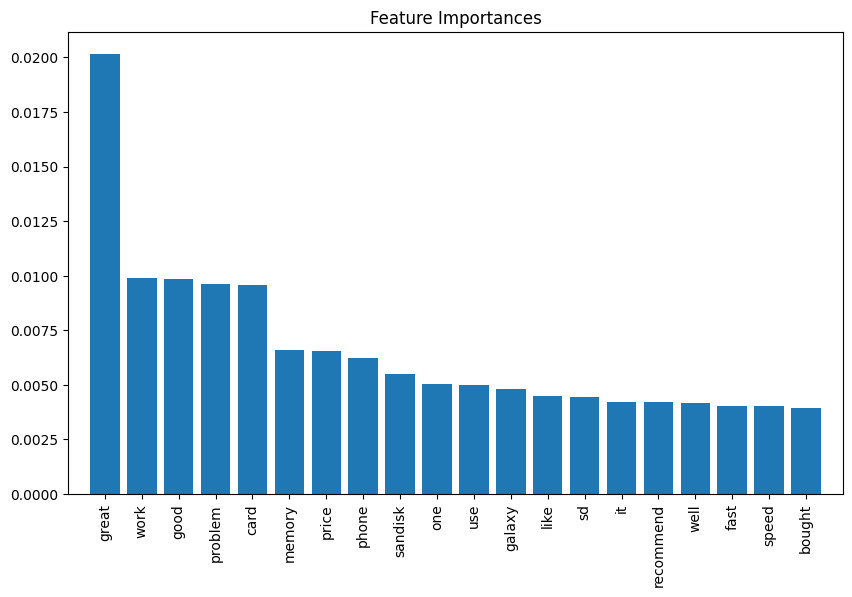

In [ ]:
# Get feature importances from the Random Forest model
importances = rf_model_count_final.feature_importances_
indices = np.argsort(importances)[::-1]

# Get feature names from the CountVectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(20), importances[indices][:20], align="center")
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
plt.xlim([-1, 20])
plt.show()


In [ ]:
def predict_count(vectorizer, model, new_comment):
    new_comment= pd.Series(new_comment)
    new_comment_vectorized = vectorizer.transform(new_comment)
    result = model.predict(new_comment_vectorized)
    if result==1:
        print("Comment is Positive")
    else:
        print("Comment is Negative")



In [ ]:
# Test prediction with a known comment
predict_count(count_vectorizer, model=rf_model_count_final, new_comment = "very good  :)")


Comment is Positive


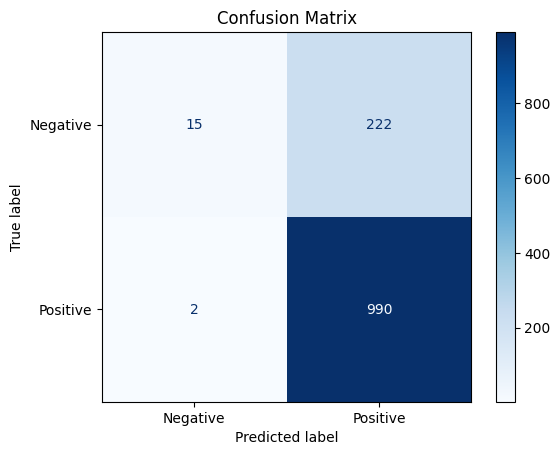

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict the sentiment on the test set
test_predictions = rf_model_count_final.predict(x_test_count_vectorizer)

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_y, test_predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
